In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/efficientnet_bf.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/BF/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/BF/val'
TEST_IMAGE_FOLDER = '/home/TBX11K/test'
SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

### EfficientNet Model

In [3]:
from tensorflow import keras
eff_model = keras.models.load_model('./weights/efficientnet_adam_dropout.hdf5')
eff_model.summary()

2022-08-15 13:54:46.248127: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-15 13:54:46.248187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

#### Keras Callbacks

In [4]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(eff_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(eff_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 9130 images belonging to 3 classes.
Found 2032 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.972310969116081, 1: 1.0144444444444445, 2: 1.0144444444444445}
samples for train class labels: dict_items([(0, 3130), (1, 3000), (2, 3000)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 923), (1, 800), (2, 309)])


#### EfficientNet Compilation and Execution

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
eff_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
warnings.filterwarnings("ignore")
epochs = 20
history = eff_model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=validation_generator, 
                                epochs=epochs,
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 1/20


2022-08-15 13:55:27.596817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


286/286 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9238 - AUC: 0.9879 - precision: 0.9298 - recall: 0.9188
Epoch 00001: val_loss improved from inf to 0.18944, saving model to ./weights/efficientnet_bf.hdf5
End of epoch 0. Learning rate: 1e-04
286/286 [==============================] - 120s 387ms/step - loss: 0.2049 - accuracy: 0.9238 - AUC: 0.9879 - precision: 0.9298 - recall: 0.9188 - val_loss: 0.1894 - val_accuracy: 0.9277 - val_AUC: 0.9904 - val_precision: 0.9290 - val_recall: 0.9277 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 2/20
286/286 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9533 - AUC: 0.9948 - precision: 0.9570 - recall: 0.9506
Epoch 00002: val_loss improved from 0.18944 to 0.11971, saving model to ./weights/efficientnet_bf.hdf5
End of epoch 1. Learning rate: 1e-04
286/286 [==============================] - 114s 399ms/step - loss: 0.1272 - accuracy: 0.9533 - AUC: 0.9948 - precision: 0.9570 - recall: 0.9506 - val_los

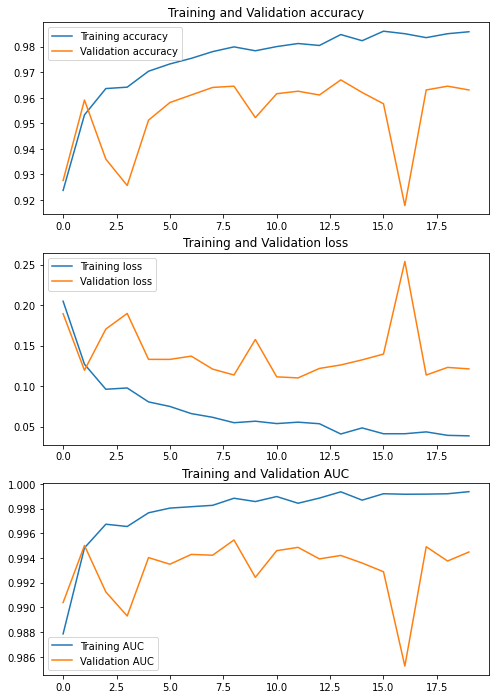

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_accuracy'],ascending=False)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
13,0.041064,0.984775,0.999362,0.985743,0.984447,0.126272,0.967028,0.994209,0.967504,0.967028,0.0001
8,0.054984,0.979956,0.998843,0.980811,0.979737,0.113886,0.964567,0.995462,0.965042,0.964567,0.0001
18,0.039382,0.985104,0.999205,0.985205,0.984666,0.123245,0.964567,0.993758,0.964532,0.963583,0.0001
7,0.061647,0.978094,0.998269,0.978934,0.977218,0.121138,0.964075,0.994227,0.965500,0.964075,0.0001
19,0.038767,0.985871,0.999375,0.986510,0.985214,0.121439,0.963091,0.994488,0.964022,0.962598,0.0001
17,0.043650,0.983571,0.999176,0.984211,0.983133,0.113836,0.963091,0.994916,0.963565,0.963091,0.0001
11,0.055647,0.981271,0.998436,0.982115,0.980394,0.110296,0.962598,0.994864,0.963986,0.961614,0.0001
14,0.048550,0.982366,0.998689,0.982681,0.981928,0.132568,0.962106,0.993597,0.962069,0.961122,0.0001
10,0.053918,0.980066,0.998981,0.981445,0.979080,0.111597,0.961614,0.994595,0.962088,0.961614,0.0001


#### EfficientNet Fine tuning

In [10]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [11]:
history_finetune = eff_model.fit(train_generator,
                            epochs=35,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 20/35
286/286 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9921 - AUC: 0.9996 - precision: 0.9922 - recall: 0.9921
Epoch 00020: val_loss improved from 0.11030 to 0.10970, saving model to ./weights/efficientnet_bf.hdf5
End of epoch 19. Learning rate: 1e-05
286/286 [==============================] - 132s 436ms/step - loss: 0.0230 - accuracy: 0.9921 - AUC: 0.9996 - precision: 0.9922 - recall: 0.9921 - val_loss: 0.1097 - val_accuracy: 0.9685 - val_AUC: 0.9948 - val_precision: 0.9690 - val_recall: 0.9680 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 21/35
286/286 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9954 - AUC: 0.9999 - precision: 0.9955 - recall: 0.9952
Epoch 00021: val_loss did not improve from 0.10970
End of epoch 20. Learning rate: 1e-05
286/286 [==============================] - 122s 426ms/step - loss: 0.0155 - accuracy: 0.9954 - AUC: 0.9999 - precision: 0.9955 - recall: 0.9952 -

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.7])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='LR changed to 1e-5')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune2 = eff_model.fit(train_generator,
                            epochs=50,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

In [ ]:
hist_df = pd.DataFrame(history_finetune2.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

#### Montgomery County Dataset Evaluation

In [ ]:
TEST_IMAGE_FOLDER = '/home/TBX11K/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

model = tf.keras.models.load_model('./weights/efficientnet_adam_dropout.hdf5')
res = model.predict(test_generator)

- Evaluate model 

In [ ]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

#### Shenzhen Dataset Evaluation

In [ ]:
TEST_IMAGE_FOLDER = '/home/TBX11K/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

In [ ]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)